In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append("..")
import hydropt.hydropt as hd
import hydropt.iops as iops;
import lmfit

In [56]:
plt.style.use('bmh')

In [57]:
wbands_hs = np.arange(400, 711, 5)

In [58]:
# load Rrs - IOP dataset
ds = xr.load_dataset('./data/psc_rrs_iop.nc')

in case variable $b_b(550)\ /\ a(440)$ gives problems with inversion change iop dataset by setting $b_b(550)$ for detrital matter to 1/2 times $a(440)$

In [59]:
# siop for phytoplankton
aph_s = pd.read_csv('../hydropt/data/psc_absorption_se_uitz_2008.csv',
                    index_col='wavelength')

In [60]:
# absorption micros
a_micro = iops.interpolate_to_wavebands(aph_s[['micro']], wbands_hs)
# absorption nanos
a_nano = iops.interpolate_to_wavebands(aph_s[['nano']], wbands_hs)
# absorption picos
a_pico = iops.interpolate_to_wavebands(aph_s[['pico']], wbands_hs)

../hydropt/iops.py:39: UserWarning: changed interpolation method
  warnings.warn('changed interpolation method')


In [61]:
def pico(*args):
    '''
    pico IOP model
    
    chl - concentration in mg/m3
    '''
    def iop(chl=args[0]):
        # chl specific absorption 
        a_star = a_pico['pico'].values
        bb_star = .0038*(wbands_hs/470)**-1.4

        return chl*np.array([a_star.reshape(-1), bb_star])
    
    def gradient(*args):
        d_a = a_pico['pico'].values
        d_bb = .0038*(wbands_hs/470)**-1.4

        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

def nano(*args):
    '''
    nano IOP model
    
    chl - concentration in mg/m3
    '''
    def iop(chl=args[0]):
        # chl specific absorption 
        a_star = a_nano['nano'].values
        bb_star = .0038*(wbands_hs/470)**-1.4

        return chl*np.array([a_star.reshape(-1), bb_star])

    def gradient(*args):
        d_a = a_nano['nano'].values
        d_bb = .0038*(wbands_hs/470)**-1.4

        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

def micro(*args):
    '''
    micro IOP model
    
    chl - concentration in mg/m3
    '''
    def iop(chl=args[0]):
        # chl specific absorption 
        a_star = a_micro['micro'].values
        bb_star = .0004*(wbands_hs/470)**.4

        return chl*np.array([a_star.reshape(-1), bb_star])
    
    def gradient(*args):
        d_a = a_micro['micro'].values
        d_bb = .0004*(wbands_hs/470)**.4

        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

In [62]:
def detrital_matter(*args):
    '''
    IOP model for detrital matter
    '''
    # vectorized
    def iop(spm=args[0]):
        a = np.exp(-.0123*(wbands_hs-440))
        bb = (.21*spm**-.21)*(550/wbands_hs)
       #bb = .5*(550/wbands_hs)
        
        return spm*np.array([a, bb])
    
    def gradient(spm=args[0]):
        d_a = np.exp(-.0123*(wbands_hs-440))
        d_bb = .21*.79*spm**-.21*(550/wbands_hs)
        
        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

In [63]:
def cdom(*args):
    '''
    IOP model for CDOM
    '''
    def iop(a_440=args[0]):
        a = a_440*np.exp(-0.0177*(wbands_hs-440))
        bb = np.zeros(len(wbands_hs))
        
        return np.array([a, bb])
    
    def gradient(*args):
        d_a = np.exp(-0.0177*(wbands_hs-440))
        d_bb = np.zeros(len(wbands_hs))
        
        return np.array([d_a.reshape(-1), d_bb])
    
    return iop, gradient

In [64]:
# initiate IOP model
iop_model = iops.BioOpticalModel()
iop_model.set_iop(
    wavebands=wbands_hs,
    pico=pico,
    nano=nano,
    micro=micro,
    dm = detrital_matter,
    cdom = cdom)

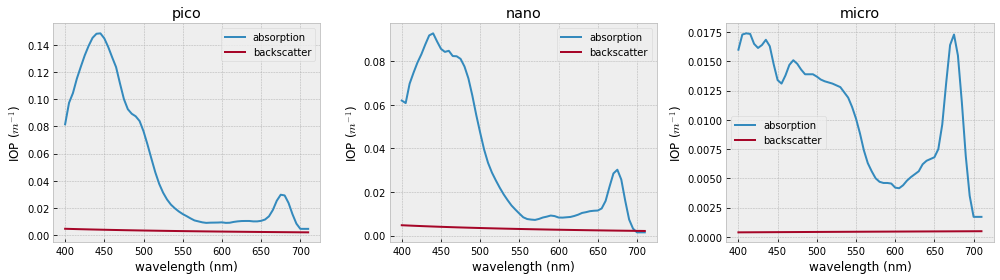

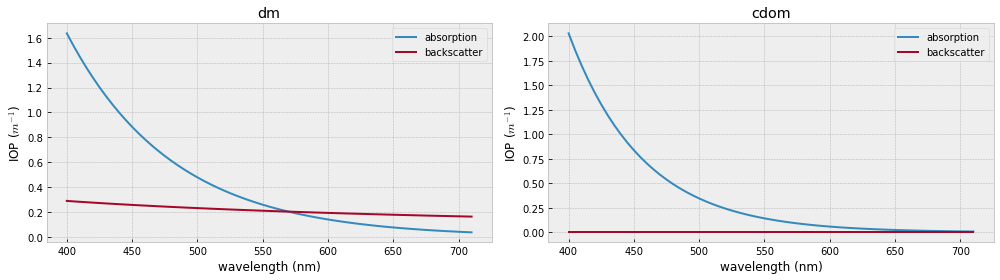

In [65]:
iop_model.plot(pico=1, nano=1, micro=1)
iop_model.plot(dm=1, cdom=1)

In [66]:
# initiate forward model
fwd_model = hd.PolynomialForward(iop_model)

In [67]:
# inverse model
inv_model = hd.InversionModel(fwd_model=fwd_model, minimizer=lmfit.minimize)

In [68]:
# set initial guess parameters close to measured values
x0 = lmfit.Parameters()
#3 comp model
x0.add('cdom', value=.02, min=1E-9)
x0.add('dm', value=.05, min=1E-9)
x0.add('pico', value=.6, min=1E-9)
x0.add('nano', value=.6, min=1E-9)
x0.add('micro', value=.6, min=1E-9)

In [80]:
y_hat = ds.rrs.groupby('no').apply(inv_model.invert, x=x0)

CPU times: user 50.6 s, sys: 62.6 ms, total: 50.6 s
Wall time: 50.7 s


In [71]:
y_hat.to_netcdf('data/psc_rrs_inversion.nc')